In [30]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
import pandas as pd
%matplotlib inline

In [77]:
IDS_df = pd.read_csv("./Data/CSE-CIC-IDS2018/03-02-2018.csv")

# To display the top 5 rows
IDS_df.head(5)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [78]:
# print shape before dropping NaN rows
print(IDS_df.shape)

(1048575, 80)


In [79]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

8100


In [80]:
#  first replace infs to NaN:
IDS_df = IDS_df.replace([np.inf, -np.inf], np.nan)

In [81]:
# print shape after dropping NaN rows
IDS_df = IDS_df.dropna()
print(IDS_df.shape)
IDS_df = IDS_df.reset_index(drop=True)

(1044525, 80)


In [82]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


Examine the proportion of types of traffic:

In [83]:
y = IDS_df["Label"].values
from collections import Counter

Counter(y).most_common()

[('Benign', 758334), ('Bot', 286191)]

Convert all non-normal observations into a single class:

In [84]:
def label_anomalous(text):
    """Binarize target labels into normal or anomalous."""
    if text == "Benign":
        return 0
    else:
        return 1

IDS_df["Label"] = IDS_df["Label"].apply(label_anomalous)

In [85]:
y = IDS_df["Label"].values
counts = Counter(y).most_common()
contamination_parameter = counts[1][1] / (counts[0][1] + counts[1][1])

Convert all categorical features into numerical form:

In [ ]:
from sklearn.preprocessing import LabelEncoder

encodings_dictionary = dict()
for c in IDS_df.columns:
    if IDS_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        IDS_df[c] = encodings_dictionary[c].fit_transform(IDS_df[c])

Split the dataset into normal and abnormal observations:

In [87]:
IDS_df_normal = IDS_df[IDS_df["Label"] == 0]
IDS_df_abnormal = IDS_df[IDS_df["Label"] == 1]
y_normal = IDS_df_normal.pop("Label").values
X_normal = IDS_df_normal.values
y_anomaly = IDS_df_abnormal.pop("Label").values
X_anomaly = IDS_df_abnormal.values

Train-test split the dataset:

In [88]:
from sklearn.model_selection import train_test_split

X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(
    X_normal, y_normal, test_size=0.3, random_state=11
)
X_anomaly_train, X_anomaly_test, y_anomaly_train, y_anomaly_test = train_test_split(
    X_anomaly, y_anomaly, test_size=0.3, random_state=11
)

import numpy as np

X_train = np.concatenate((X_normal_train, X_anomaly_train))
y_train = np.concatenate((y_normal_train, y_anomaly_train))
X_test = np.concatenate((X_normal_test, X_anomaly_test))
y_test = np.concatenate((y_normal_test, y_anomaly_test))

Instantiate and train an isolation forest classifier:

In [89]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(contamination=contamination_parameter)
IF.fit(X_train)

IsolationForest(contamination=0.2739915272492281)

Score the classifier on normal and anomalous observations:

In [90]:
decisionScores_train_normal = IF.decision_function(X_normal_train)
decisionScores_train_anomaly = IF.decision_function(X_anomaly_train)

Plot the scores for the normal set:

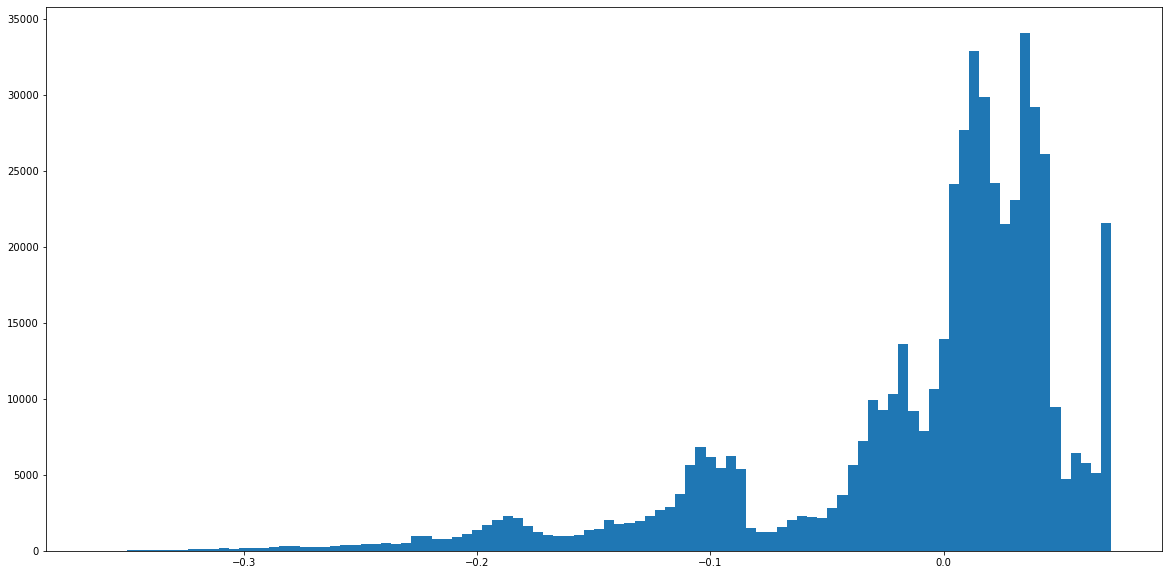

In [94]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(20, 10))
_ = plt.hist(decisionScores_train_normal, bins=100)

plot the scores on the anomalous observations for a visual examination:

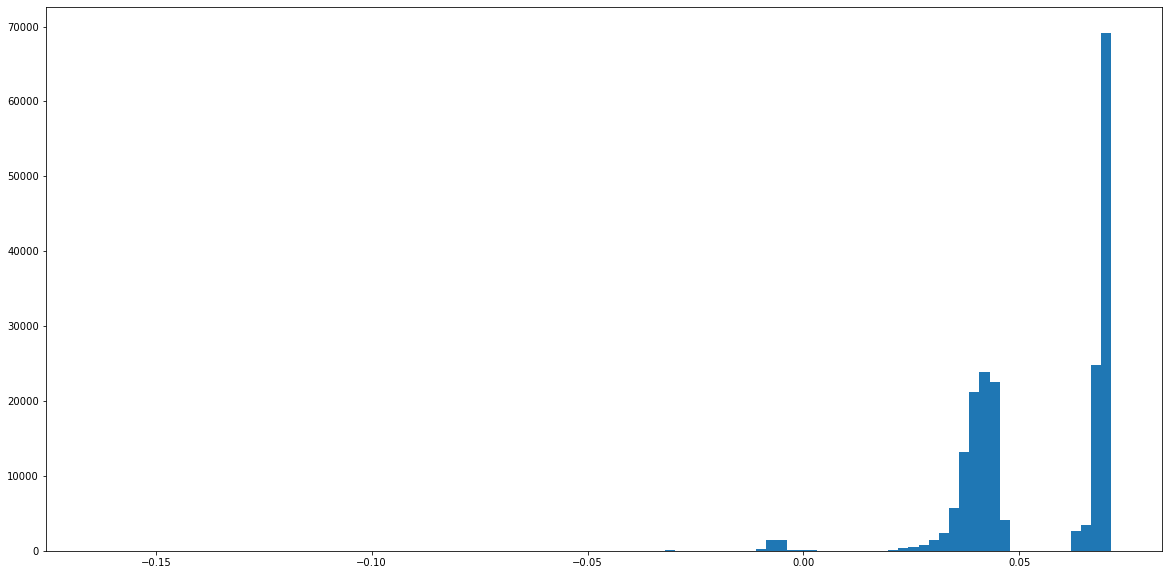

In [93]:
plt.figure(figsize=(20, 10))
_ = plt.hist(decisionScores_train_anomaly, bins=100)

In [104]:
cutoff = 0.010

In [105]:
print(Counter(y_test))
print(Counter(y_test[cutoff < IF.decision_function(X_test)]))

Counter({0: 227501, 1: 85858})
Counter({0: 120568, 1: 84227})


As can be seen above we are catching almost all the anomalies with a cutoff of 0.010 for this test dataset.